# Химия и рекуррентные сети

Для работы с химическими формулами можно использовать рекуррентные нейронные сети, если предположить, что последовательность химических злементов вполне похожа на слова естественного языка.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 6.4 MB/s eta 0:00:00


In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Работа с данными

In [41]:
df = pd.read_excel('35000.xlsx')
df = df.drop("Unnamed: 0", axis = 1)

В случае работы с рекуррентной нейронной сетью нам придётся отдельно смотреть на то, какой длинны у нас описания молекул. Сделаем это сразу.

In [42]:
df['S_leng'] = df['SMILES'].str.len ()

In [43]:
df.head()

,Title,IC50,SMILES,S_leng
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,66
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,52
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,55
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,53
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,55


In [44]:
df.describe()

,IC50,S_leng
count,36377.000000,36377.000000
mean,7.813503,47.849108
std,48.489710,16.990337
min,0.000010,7.000000
25%,1.696000,37.000000
50%,3.635000,45.000000
75%,5.934000,55.000000
max,3183.600000,281.000000


З

<Axes: xlabel='S_leng', ylabel='Count'>

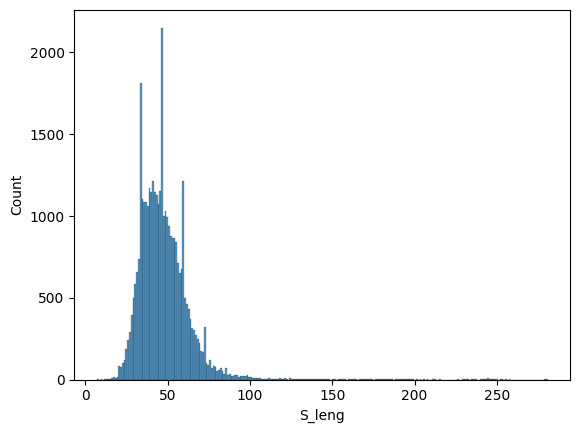

In [14]:
sns.histplot(df['S_leng'])

<Axes: xlabel='IC50', ylabel='Count'>

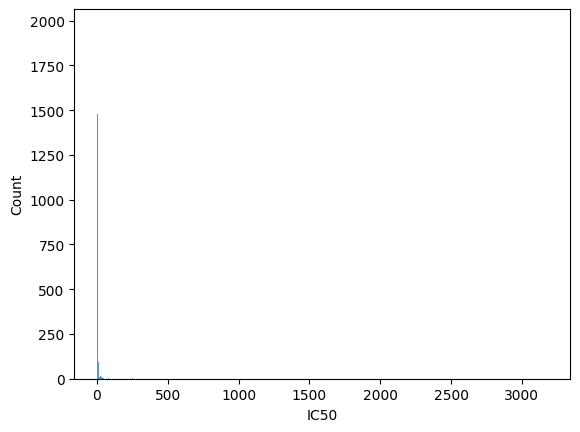

In [16]:
sns.histplot(df['IC50'])

Отброси те значения, которые нас не устраивают.

In [49]:
df = df[df['IC50'] < 120]
df = df[df.S_leng < 100]

In [50]:
df.columns

Index(['Title', 'IC50', 'SMILES', 'S_leng'], dtype='object')

In [51]:
df_w = df[[ 'IC50', 'SMILES']]

In [52]:
df_w.describe()

,IC50
count,35752.000000
mean,5.069229
std,8.688781
min,0.000010
25%,1.672000
50%,3.599000
75%,5.798000
max,119.347000


## Векторайзер и подготовка обучению

Прежде, чем начать обучение, необходмо преобразовать молекулы в понятные для машины цифры. Сделаем это с помощью векторазйера mol2vec, который по смыслу похож на векторайзер word2vec.

In [ ]:
OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2

In [53]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,<rdkit.Chem.rdchem.Mol object at 0x790d058bd4d0>
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,<rdkit.Chem.rdchem.Mol object at 0x790d058bc270>
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,<rdkit.Chem.rdchem.Mol object at 0x790d058be420>
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,<rdkit.Chem.rdchem.Mol object at 0x790d058be810>
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,<rdkit.Chem.rdchem.Mol object at 0x790d058be8f0>
...,...,...
36100,C1C=CC(=O)N(C2)[C@H]1[C@H]([C@@H]3[C@]24O)CCCN...,<rdkit.Chem.rdchem.Mol object at 0x790d056ca2d0>
36101,COc1c(C)c(O)c(C)c(c12)occ(c2=O)-c3ccccc3,<rdkit.Chem.rdchem.Mol object at 0x790d056ca340>
36102,s1c(Br)ccc1C(=O)/C=C\c2ccc(cc2)/C=N/Nc3nc(N4CC...,<rdkit.Chem.rdchem.Mol object at 0x790d056ca3b0>
36103,c1ccccc1CNC(\C)=C(/C2=O)C(=O)Oc(c23)c(F)c(c(F)...,<rdkit.Chem.rdchem.Mol object at 0x790d056ca420>


In [54]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-wfj9azjw
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-wfj9azjw
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done


In [55]:
from molvecgen.vectorizers import SmilesVectorizer

In [56]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

В итоге мы получаем совершенно неясную нам последовательность у которой размерность составляет 102 на 42.

In [57]:
print(smivec.charset)
smivec.dims

O\NIC]l[+P7ZsB/2-()ne51Fa#iH@.S=346cro^$?


(102, 41)

In [58]:
print("Maximum allowed SMILES length %s"%smivec.maxlength)

Maximum allowed SMILES length 101


Создадим наши выборки.

In [59]:
y = df_w['IC50'].values.reshape((-1,1))
X = df_w.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [28]:
y_train

array([[-0.22891781],
       [-0.4453571 ],
       [-0.27943179],
       ...,
       [-0.2901346 ],
       [ 0.30930337],
       [-0.42229798]])

Сделаём датасет.

In [30]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [60]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[78]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([0.51210217]))

In [61]:

X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

cuda:0


torch.Size([5363, 102, 41])

In [33]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size//2) # Output layer
        self.activation2 = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(x) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.fc2(out) # Pass into the hidden layer
        out = self.activation2(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

Зададим параметры сети.

In [64]:
epochs = 50
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.3 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.001  # The initial learning rate for the optimizer

In [65]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): GRU(41, 32, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [66]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[-0.1666]]], device='cuda:0', grad_fn=<ViewBackward0>)

Определим параметры обучения.

In [67]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


Создадим загрузчик.

In [68]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Обязательно заглянем внутрь.

In [69]:
for smiles, labels in train_loader:
    print(smiles)
    print(labels)
    break

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

## Обучим модель

In [70]:
model.train() # Переводим сеть в режим обучения
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Переносим всё на видеокарту
        smiles = torch.tensor(smiles, device=device).float()
        #print(smiles)
        labels = torch.tensor(labels, device=device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Начинаем обучение
        optimizer.zero_grad() # Обнуляем градиенты

        output = model(smiles) # Шаг обучения
        loss = criterion(output, labels) # Считаем значение функции потерь
        loss.backward() # считаем градиенты
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # оптимизируем параметры

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


<ipython-input-70-37434c2c50fc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smiles = torch.tensor(smiles, device=device).float()
<ipython-input-70-37434c2c50fc>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device).float()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([1, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWa

Epoch 5, Training loss: 0.97 Validation loss: 1.00
Epoch 10, Training loss: 0.97 Validation loss: 1.00
Epoch 15, Training loss: 0.96 Validation loss: 0.99
Epoch 20, Training loss: 0.95 Validation loss: 0.98
Epoch 25, Training loss: 0.94 Validation loss: 0.98
Epoch 30, Training loss: 0.95 Validation loss: 0.98
Epoch 35, Training loss: 0.93 Validation loss: 0.97
Epoch 40, Training loss: 0.93 Validation loss: 0.97
Epoch 45, Training loss: 0.92 Validation loss: 0.96
Epoch 50, Training loss: 0.92 Validation loss: 0.95


Визуализируем, что происходит.

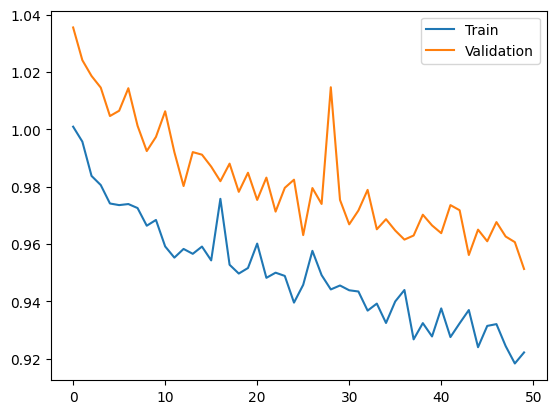

In [71]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

## Протестируем модель

In [73]:
model.eval() # Переведём модель в режим оценки
y_pred_validation = model(X_validation_t)


In [74]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.9512447714805603

In [75]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))

In [76]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.905	Test RMSE: 0.874


In [77]:
y_pred_train.shape

torch.Size([1, 21451, 1])

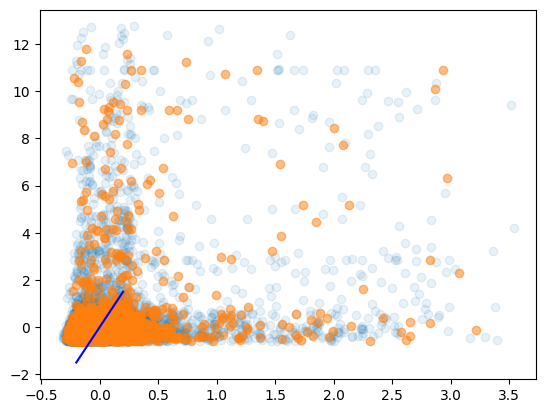

In [78]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-0.2, 0.2], [-1.5,1.5], c="b")
#plt.xlim(-1,  1)
#plt.ylim(-0.1,  1)